In [2]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchnmf.nmf import NMF, NMFD, AdditiveNoise, MultiplicativeNoise
from torchnmf.metrics import kl_div, beta_div
from torchnmf.trainer import AdaptiveMu
import librosa
import IPython.display as ipd

In [3]:
audio_ogg = librosa.util.example('libri2')

x, sr = librosa.load(audio_ogg)
x = torch.from_numpy(x)

windowsize = 2048
X = torch.stft(x, windowsize,
               window=torch.hann_window(windowsize),
               return_complex=True).abs()
X = np.log10(X+1)
X = X.unsqueeze(0)


# Generate some labels
Y = torch.zeros((1,1,X.shape[-1]));
"""
Y[0, 0, 432:532] = 1;
Y[0, 0, 759:859] = 1;
Y[0, 0, 1459:1559] = 1;
Y[0, 0, 1759:1859] = 1;
"""

'\nY[0, 0, 432:532] = 1;\nY[0, 0, 759:859] = 1;\nY[0, 0, 1459:1559] = 1;\nY[0, 0, 1759:1859] = 1;\n'

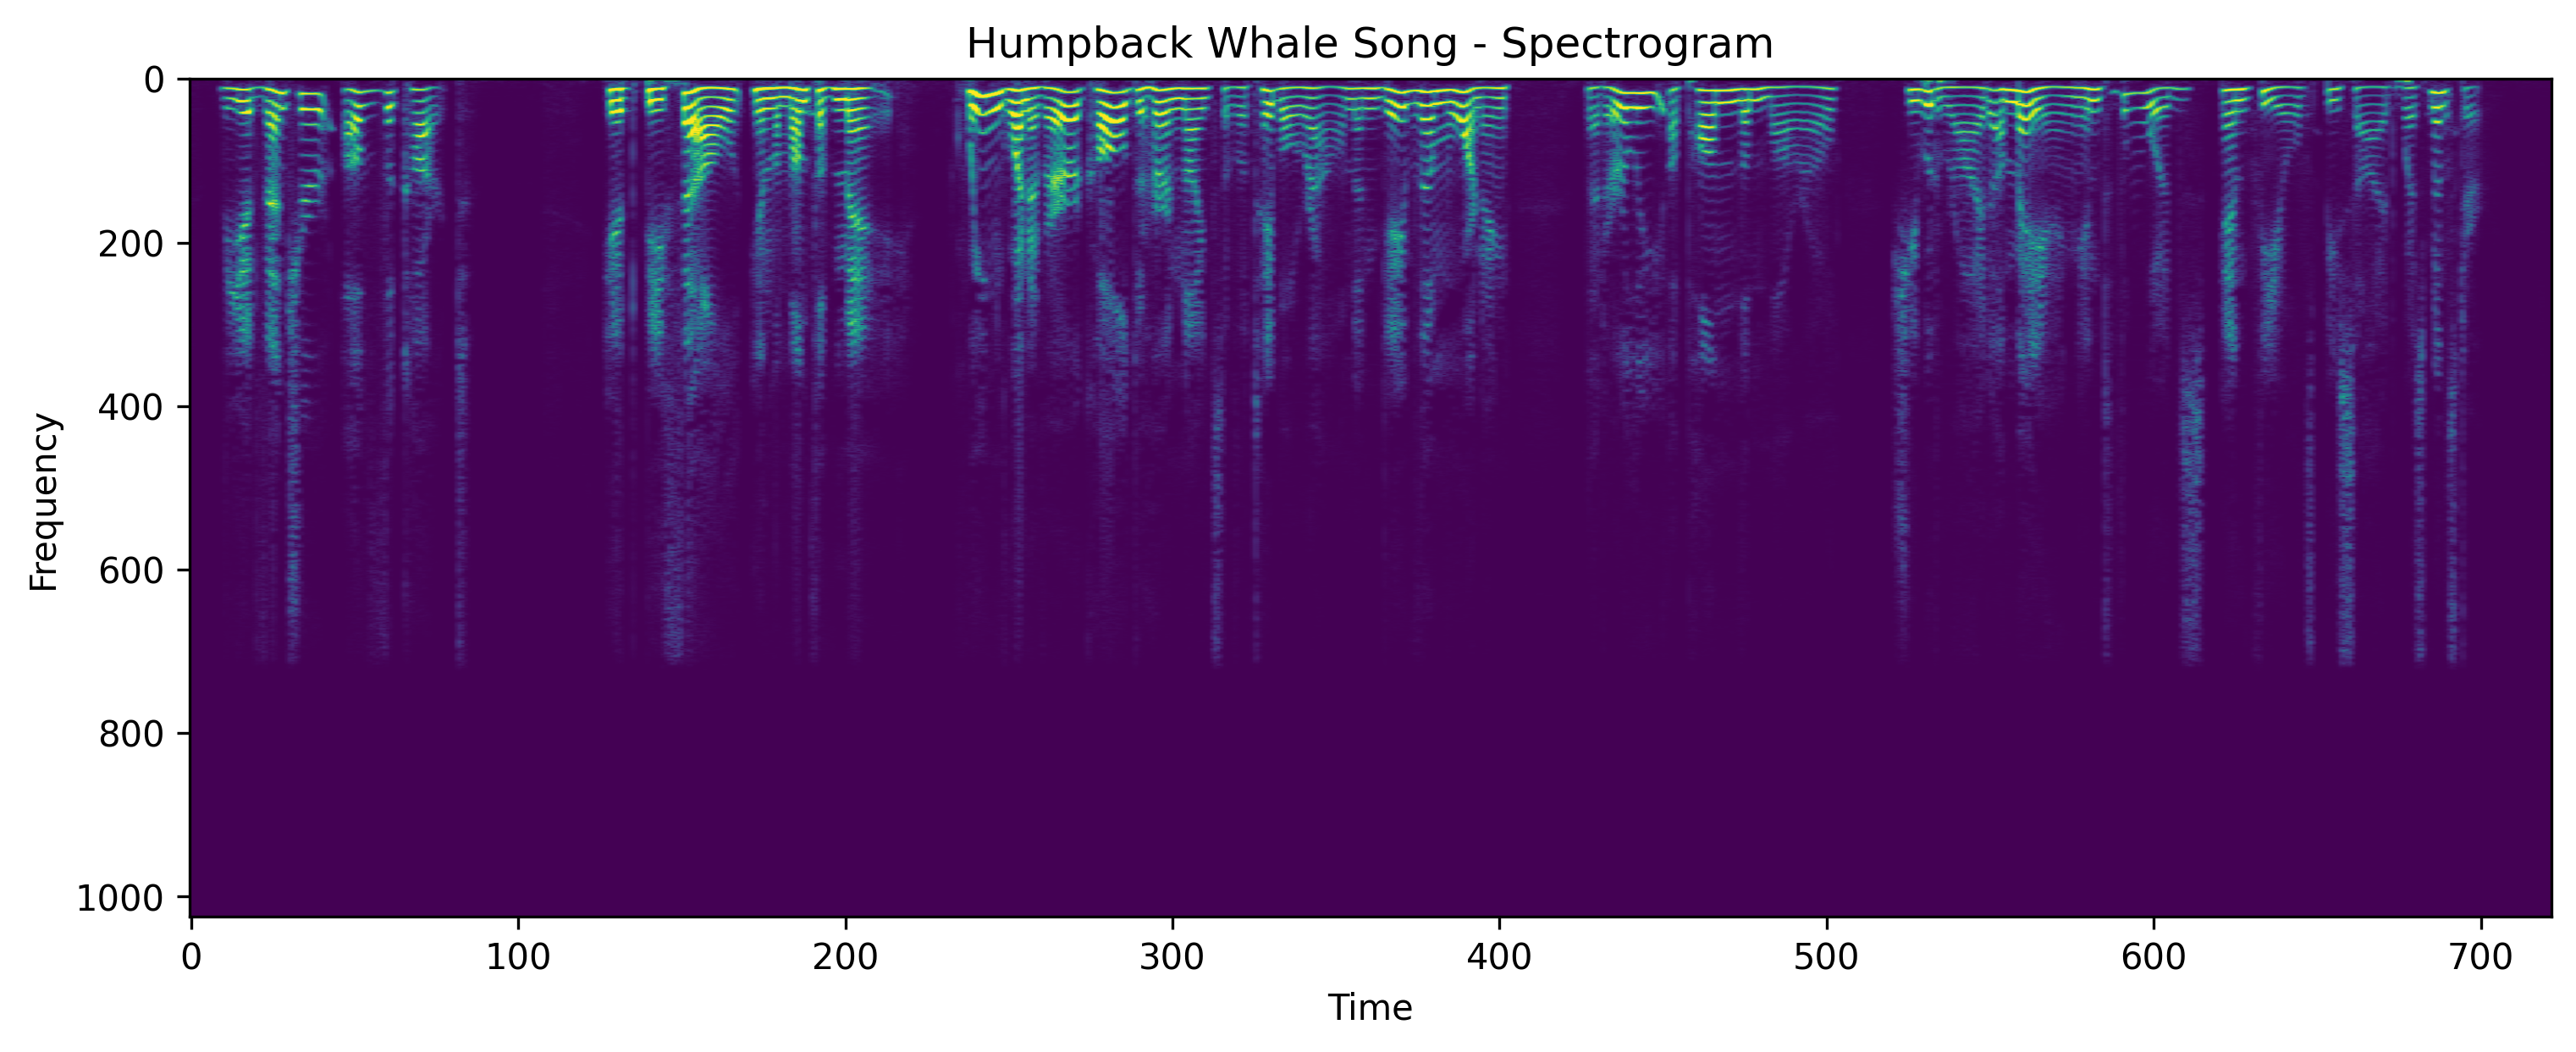

In [4]:
plt.figure(figsize=(12,6), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(X[0].detach(), vmin=0, vmax=1.5, aspect=0.25); 
ax.plot(Y[0,0].detach()*1025, color='w', linewidth=0.5)
ax.set_title('Humpback Whale Song - Spectrogram')
ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
#plt.colorbar(mat, ax=ax);
plt.show()

NameError: name 'model' is not defined

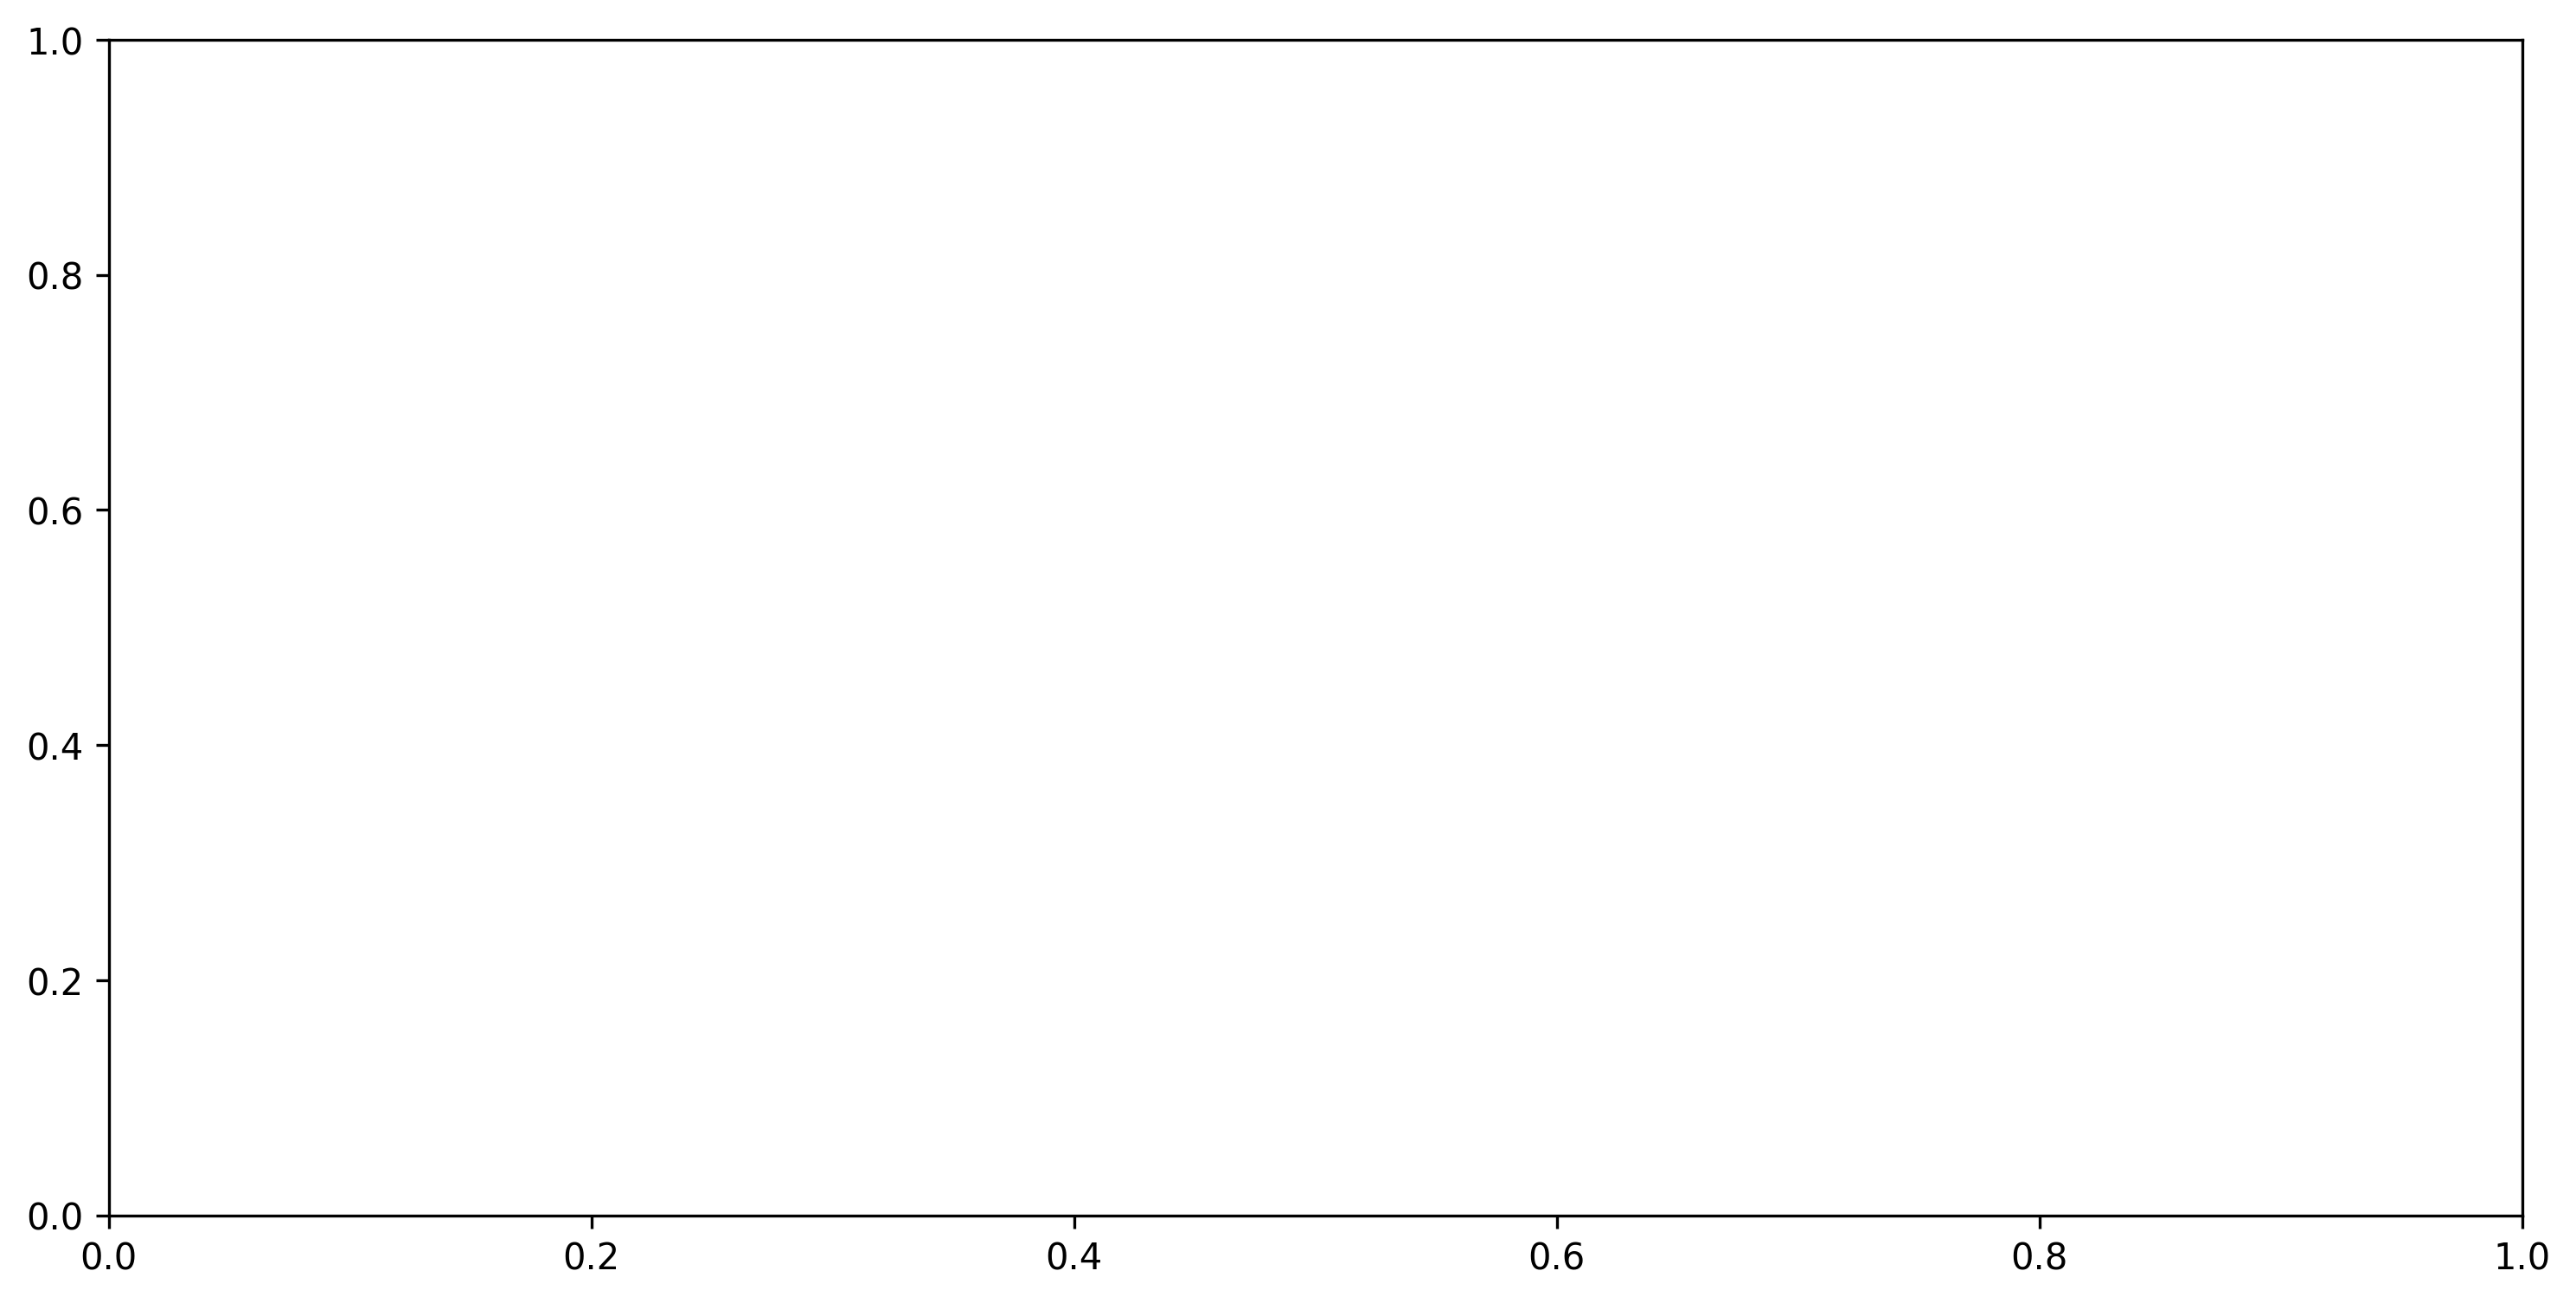

In [5]:
plt.figure(figsize=(12,6), dpi=300)
ax = plt.subplot(111)
mat = ax.imshow(model.mdl_feats()[0].detach(), vmin=0, vmax=1.5, aspect=0.25); 
ax.plot(Y[0,0].detach()*1025, color='w', linewidth=0.5)
ax.set_title('Humpback Whale Song - Spectrogram')
ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
#plt.colorbar(mat, ax=ax);
plt.show()

In [6]:
try:
    del model, trainer, CNMFSemiSup
except:
    pass

class CNMFSemiSup(nn.Module):
    def __init__(self, rank, conv_win):
        super().__init__()
        self.mdl_feats = NMFD(X.shape, rank=rank, T=conv_win)
        self.mdl_class = NMFD(Y.shape, rank=rank, T=conv_win)
        self.mdl_feats.H = self.mdl_class.H
        
    def forward(self):
        lay_feats = self.mdl_feats()
        lay_class = self.mdl_class(H=self.mdl_feats.H)
        return lay_feats, lay_class

    def loss(self, X, Y, beta_x, beta_y):
        io_dict = {}
        for p in self.mdl_feats.parameters():
            if id(p) not in io_dict: io_dict[id(p)] = list()
            io_dict[id(p)].append(lambda: (X, self()[0], beta_x))

        """
        for p in self.mdl_class.parameters():
            if id(p) not in io_dict: io_dict[id(p)] = list()
            io_dict[id(p)].append(lambda: (Y, self()[1], beta_y))
        """

        return io_dict
                
model = CNMFSemiSup(rank=6, conv_win=20)
trainer = AdaptiveMu([
    {'params': [model.mdl_feats.W], 'theta':1},
    #{'params': [model.mdl_class.W], 'theta':1},    
    {'params': [model.mdl_feats.H], 'theta':1}
])

In [7]:
epochs = 200
for e in tqdm(range(epochs)):
    def closure():
        trainer.zero_grad()
        return model.loss(X, Y, 0, 2)
    trainer.step(closure)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.79it/s]


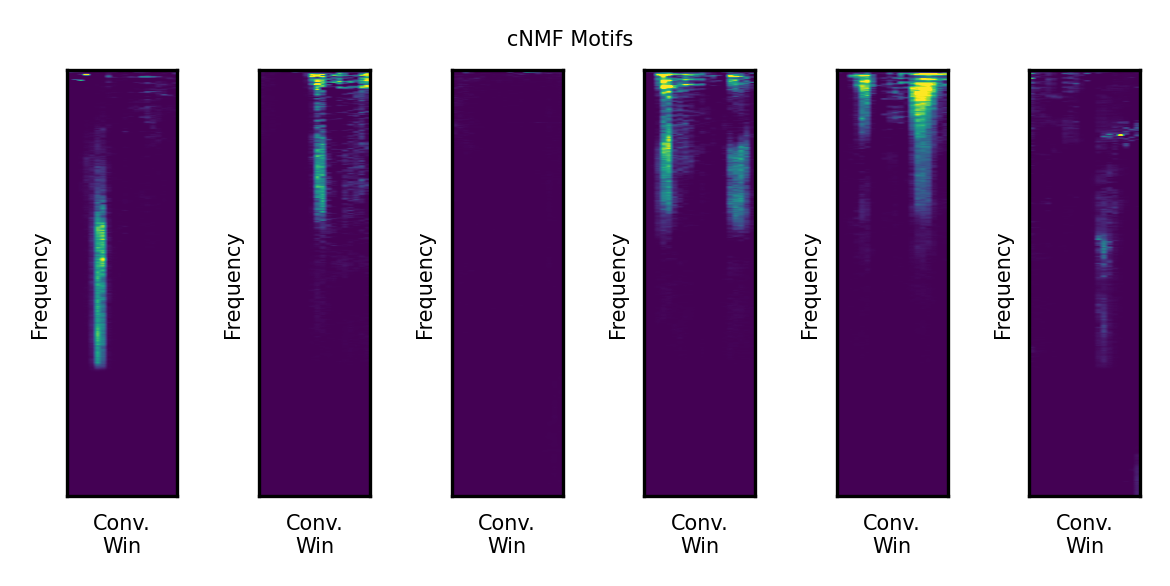

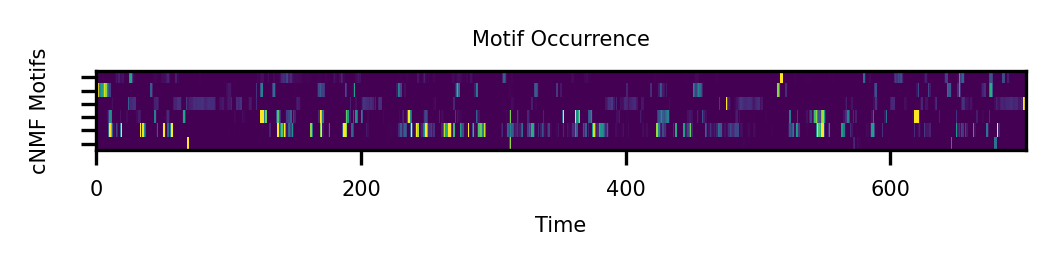

In [8]:
WW = model.mdl_feats.W.detach()
for r in range(model.mdl_feats.rank):
    WW[:,r,:] = (WW[:,r,:] - WW[:,r,:].min()) / (WW[:,r,:].max() - WW[:,r,:].min())
    
HH = model.mdl_feats.H.detach()
for r in range(model.mdl_feats.rank):
    HH[:,r,:] = (HH[:,r,:] - HH[:,r,:].min()) / (HH[:,r,:].max() - HH[:,r,:].min())    

###
plt.figure(figsize=(4,16), dpi=300)
for r in range(WW.shape[1]):
    ax = plt.subplot(1,WW.shape[1],r+1)
    ax.imshow(WW[:,r,:].numpy()[:,::-1], vmin=0, vmax=0.5, aspect=0.075)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('Frequency', fontsize=5)
    ax.set_xlabel('Conv.\nWin', fontsize=5)
    if r == WW.shape[1] // 2-1:
        ax.set_title('                   cNMF Motifs', fontsize=5)
plt.tight_layout()
plt.show()

###
plt.figure(figsize=(4,16), dpi=300)
ax = plt.subplot(111)
ax.imshow(HH[0], interpolation='none', vmin=0.0, vmax=0.5, aspect=10)
ax.set_yticks(np.arange(HH.shape[1]))
ax.set_yticklabels([])
ax.set_ylabel('cNMF Motifs', fontsize=5)
ax.set_xlabel('Time', fontsize=5)
ax.set_title('Motif Occurrence', fontsize=5)
for axg in ax.get_xticklabels(): axg.set_fontsize(5)
plt.show()

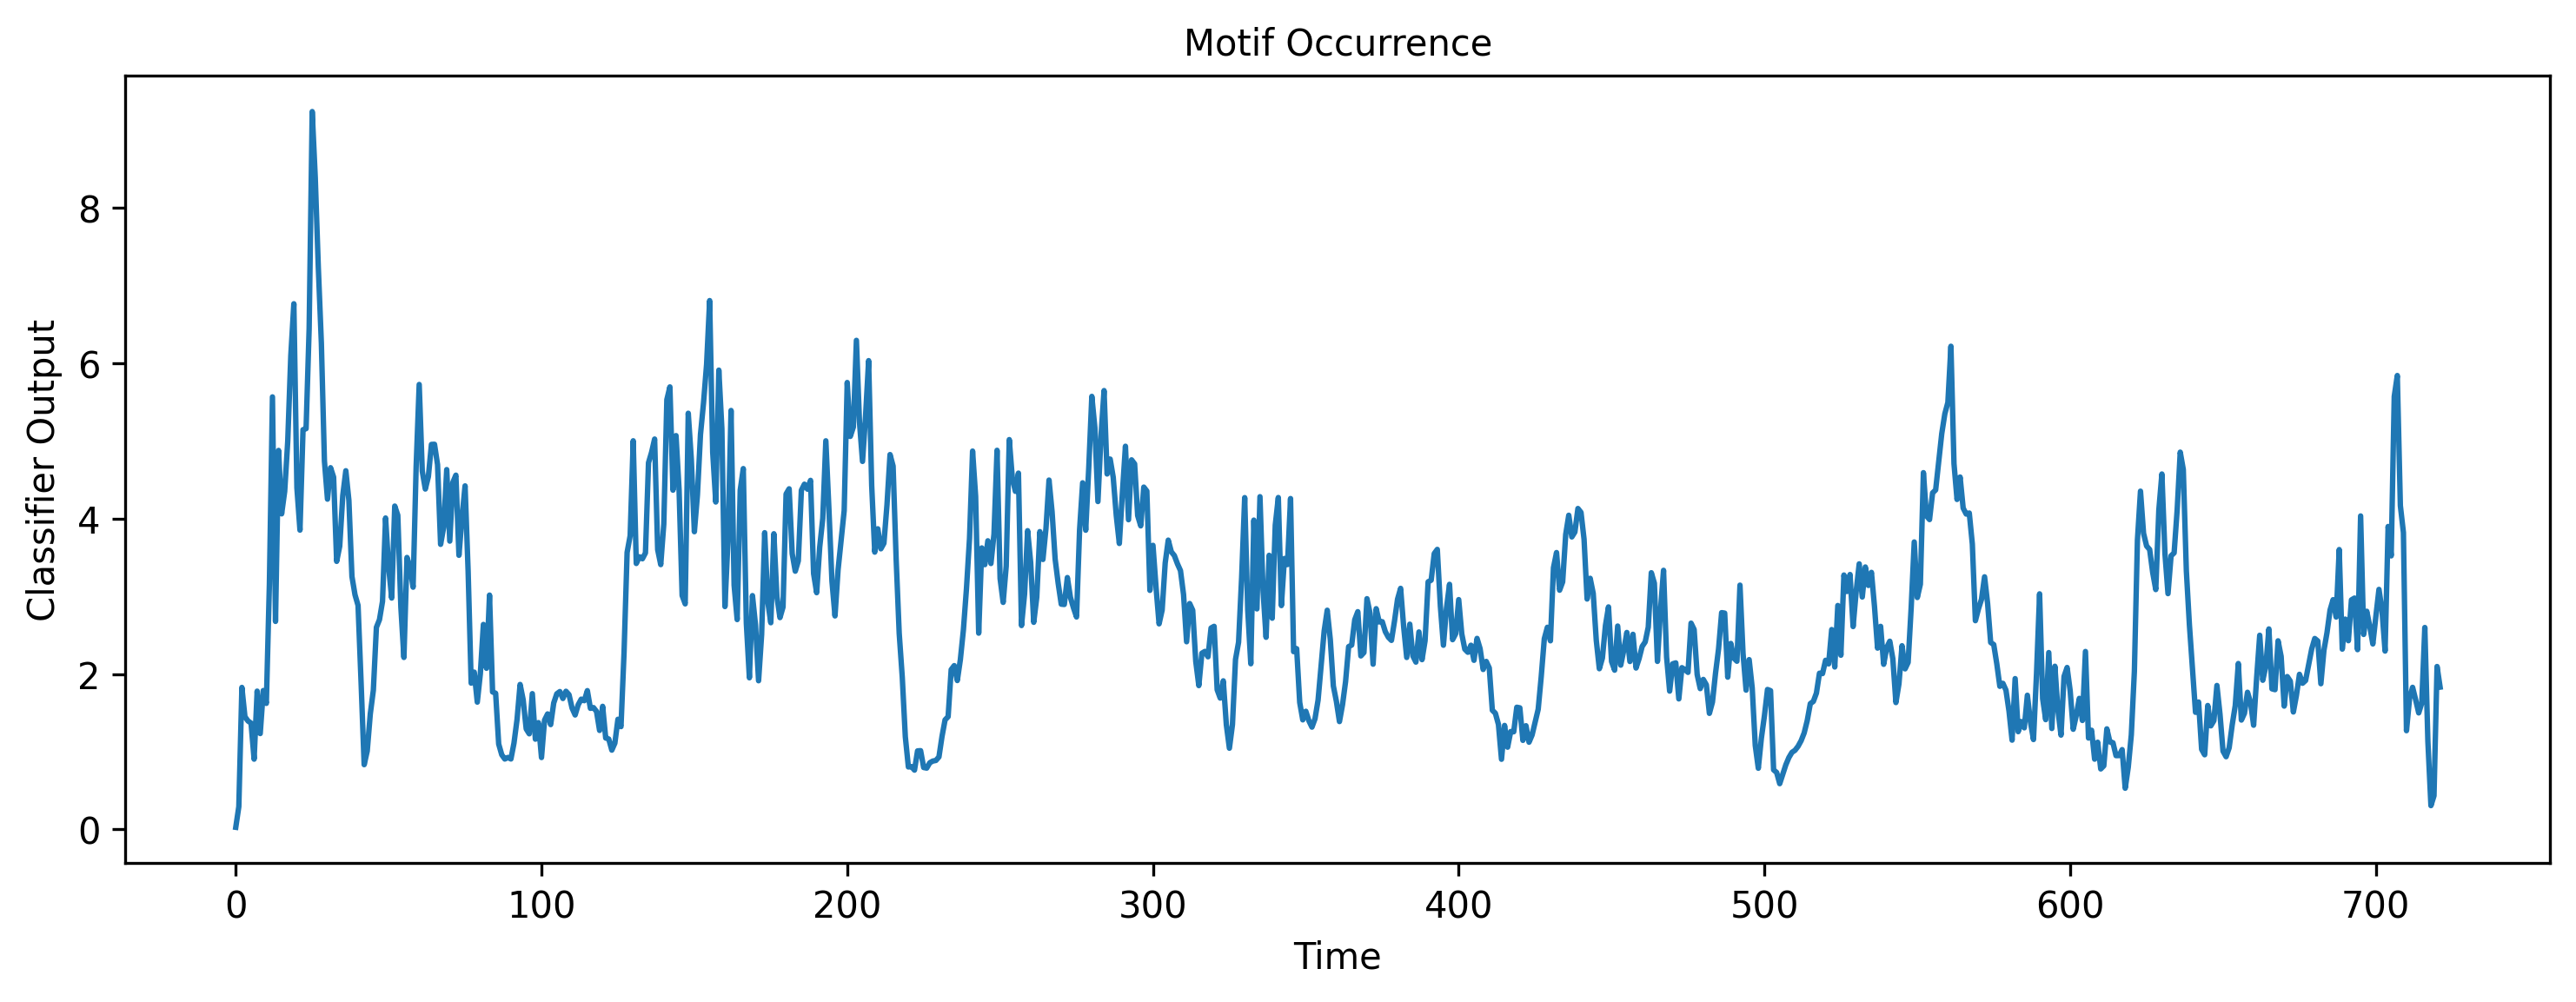

In [23]:
###
plt.figure(figsize=(12,4), dpi=300)
ax = plt.subplot(111)
ax.plot(model.mdl_class()[0,0].detach())
ax.set_ylabel('Classifier Output', fontsize=10)
ax.set_xlabel('Time', fontsize=10)
ax.set_title('Motif Occurrence', fontsize=10)
plt.show()

In [39]:
# Generate some labels
Y = torch.zeros((1,1,X.shape[-1]));

Y[0, 0, 49:159] = 1;
Y[0, 0, 359:459] = 1;
Y[0, 0, 659:759] = 1;

torch.Size([1025, 2792])